# PRÁCTICA FINAL 

**Machine Learning: Modelos Supervisados**

*Autores: Marta Delgado, Susana Jodra, Marta Onieva, Loreto Torres*

------

## Librerías

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from  sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import Image
from IPython.core.display import HTML 

## Introducción

En esta práctica nos encontramos ante un problema de clasificación: vamos a obtener una variable categórica como respuesta. Para este ejercicio obtendremos los datos de **Canadian Car Accidents 1994-2014**. Analizaremos en profundidad las siguientes cuestiones:

- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?
- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?
- ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?
- Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas.
- Libertad para generar análisis de valor y nuevas ideas. Se debe atacar mínimo un modelo (estimar si habrá fallecidos o no). Hecho esto, se puede plantear de forma opcional otros alcances (libertad para plantear opciones).
- Plus: complementar con datos abiertos de clima (aunque Canadá es muy grande) y de otra tipología, ¿hay algún tipo de relación con temperaturas medias, precipitación media del día/mes, nieve...? ¿a más días festivos o de vacaciones, más accidentes? etc.


In [2]:
Image(url= "https://www.callkleinlawyers.com/wp-content/uploads/2019/08/burnaby-car-accident.jpg")

## 1. Datos:

En primer lugar importamos los datos. El dataset usado será obtenido de: https://www.kaggle.com/datasets/tbsteal/canadian-car-accidents-19942014?select=drivingLegend.pdf

In [3]:
db = pd.read_csv("NCDB_1999_to_2014.csv")

In [4]:
print(db.shape)
db.head(5)

(5860405, 22)


,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3


### 1.1 ANÁLISIS Y ESTUDIO INICIAL 

El dataset con el que vamos a trabajar trata información que hace referencia a los accidentes de tráfico en Canada desde 1999 hasta 2014. Vemos que la información se compone de datos sobre las personas relacionadas con el accidente (`P_`), datos relativos al accidente (`C_`) y por último, datos relativos al vehículo involucrado (`V_`).

La leyenda y significado de cada una de las variables se encuentra, en la carpeta `Information` del repositorio, bajo el nombre `drivingLegend`. La primera página incluye un pequeño resumen del dataset (`Canadian Car Accidents`) y de sus variables, y en el resto del documento, explica en detalle información sobre cada una de ellas. 

- **C_YEAR**: Year,
- **C_MNTH**: Month, 
- **C_WDAY**: Day of week, 
- **C_HOUR**: Collision hour, 
- **C_SEV**: Collision severity, 
- **C_VEHS**: Number of vehicles involved in collision, 
- **C_CONF**: Collision configuration,
- **C_RCFG**: Roadway configuration, 
- **C_WTHR**: Weather condition, 
- **C_RSUR**: Road surface, 
- **C_RALN**: Road alignment, 
- **C_TRAF**: Traffic control, 
- **V_ID**: Vehicle sequence number, 
- **V_TYPE**: Vehicle type,
- **V_YEAR**: Vehicle model year, 
- **P_ID**: Person sequence number, 
- **P_SEX**: Person sex, 
- **P_AGE**: Person age, 
- **P_PSN**: Person position, 
- **P_ISEV**: Medical treatment required, 
- **P_SAFE**: Safety device used,
- **P_USER**: Road user class

En general: *`UU/U`: Unknown; `XX/X`: Jurisdiction does not provide this data; `QQ/Q`: Choice is other than the preceding values; `NN`: data element nos applicable*

In [5]:
print('Tipos de datos en el dataset:')
print('------------------------------')
tipos=pd.DataFrame(db.dtypes)
tipos=tipos.rename(columns={0:'TYPE'})
tipos

Tipos de datos en el dataset:
------------------------------


,TYPE
C_YEAR,int64
C_MNTH,object
C_WDAY,object
C_HOUR,object
C_SEV,int64
C_VEHS,object
C_CONF,object
C_RCFG,object
C_WTHR,object
C_RSUR,object


El hecho de que existan variables no conocidas (U), no especificadas (X), no definida (Q) causa que la mayoría de las variables sean de tipo `object`, a pesar de estar mayoritariamente compuesta por números. Por ello, llevaremos a cabo un procesamiento de los datos:

### 1.2 TRATAMIENTO DE LOS VALORES MISSING (NA's)

In [6]:
nas=pd.DataFrame(db.isna().sum())
nas=nas.rename(columns={0:'Nº NAs'})
nas

,Nº NAs
C_YEAR,0
C_MNTH,0
C_WDAY,0
C_HOUR,0
C_SEV,0
C_VEHS,3
C_CONF,0
C_RCFG,0
C_WTHR,0
C_RSUR,0


En referencia al número de NA's en todo el conjunto de datos, vemos que simplemente hay 3 datos faltantes en la columna `C_VEHS`, asi que simplemente procedemos a eliminarlos, ya que consideramos que no afectarán al dataset general.

In [7]:
db = db.dropna()

### 1.3 UNKNOWN VALUES

A continuación, analizaremos los valores desconocidos.

Como hemos podido ver antes, y como podemos leer en la leyenda de los datos, encontramos una serie de valores desconocidos o unknown values:
   - `U`/`UU`/`UUU` : Unknown, un valor desconocido.
   - `X`/`XX`/`XXX` : Jurisdiction does not provide this data element, no se ha proporcionado el dato.
   - `Q`/`QQ`/`QQQ` : Choice is other than the preceding values, el valor es otra de las categoría conocidas.
   - `N`/`NN`/`NNN` : Data element not applicable, generalmente un peatón al que no se le aplica criterio de valoración.

Todos ellos suponen información faltante, asi, procederemos a reemplazarlos por valores outliers para no alterar el dataset. 

In [8]:
db["V_TYPE"].replace({"QQ": "24"}, inplace=True)

In [9]:
cambio_Q = ['Q', 'QQ', 'QQQQ']
cambio_N = ['N', 'NN', 'NNNN']
cambio_U = ['U', 'UU', 'UUUU']
cambio_X = ['X', 'XX', 'XXXX']

In [10]:
db = db.replace(cambio_Q, 100)
db = db.replace(cambio_N, 100)
db = db.replace(cambio_U, 100)
db = db.replace(cambio_X, 100)

In [11]:
db

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,100,1,5,...,01,06,1990,01,M,41,11,1,100,1
1,1999,1,1,20,2,02,34,100,1,5,...,02,01,1987,01,M,19,11,1,100,1
2,1999,1,1,20,2,02,34,100,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,100,5,3,...,01,01,1986,01,M,46,11,1,100,1
4,1999,1,1,08,2,01,01,100,5,3,...,99,100,100,01,M,05,99,2,100,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,2014,100,100,100,2,100,100,01,100,100,...,13,07,100,01,M,24,11,1,100,1
5860401,2014,100,100,23,2,01,06,05,1,1,...,1,14,2006,01,M,29,96,2,09,5
5860402,2014,100,100,14,2,01,02,01,1,5,...,1,01,2006,01,F,100,11,2,01,1
5860403,2014,100,100,22,1,01,06,01,2,4,...,1,22,100,01,M,67,12,3,01,100


### 1.4 FILAS REPETIDAS

Al analizar las columnas y variables del dataset, podemos concluir a priori, que cada fila no representa un accidente diferente, si no que se desglosan en ella, las personas y vehiculos implicados. Para responder a algunas de las cuestiones y predecir ciertos datos, este hecho es de gran importancia, pues solo habria que tener en cuenta el número total de accidentes.

Asi, a continuación, también es importante analizar la existencia de filas repetidas, y si fueran una cifra considerada, proceder a eliminarlas.

In [12]:
db[db.duplicated(keep = 'first')]

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
17,1999,1,1,11,2,02,34,100,1,2,...,01,06,1988,01,F,30,11,2,02,1
18,1999,1,1,11,2,02,34,100,1,2,...,02,06,1993,01,M,49,11,2,02,1
3214,1999,1,1,21,2,02,33,02,1,5,...,01,06,1998,01,M,32,11,2,02,1
3215,1999,1,1,21,2,02,33,02,1,5,...,02,01,1989,01,F,17,11,1,100,1
7119,1999,1,2,23,2,01,01,01,4,5,...,01,06,1993,01,M,35,11,2,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845016,2014,12,3,11,2,01,06,02,1,1,...,1,01,100,01,100,100,11,1,100,1
5848882,2014,12,4,08,2,02,36,02,4,5,...,1,01,2013,01,F,17,11,1,02,1
5848883,2014,12,4,08,2,02,36,02,4,5,...,1,01,2013,02,F,17,13,2,02,2
5848884,2014,12,4,08,2,02,36,02,4,5,...,2,01,2013,01,M,58,11,1,02,1


Podemos ver que hay **5,106** filas repetidas, lo cual supone solamente un **0,087%** del total de filas (**5,860,402**), por lo que no las eliminamos.

### 1.5 TRANSFORMACIÓN VARIABLES CUALITATIVAS 

Para poder llevar a cabo el análisis es necesario cambiar las variables considerdas categóricas a valores numéricos. Empezamos modificando el Sexo de las personas, y conviertiendolo en una variable dicotómica que tome los valores `0` para el sexo masculino, y `1` para el femenino.

#### 1.5.1 VARIABLE `P_SEX`

In [13]:
db.P_SEX.replace({'M':0,'F':1},inplace=True)

In [14]:
db

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,100,1,5,...,01,06,1990,01,0,41,11,1,100,1
1,1999,1,1,20,2,02,34,100,1,5,...,02,01,1987,01,0,19,11,1,100,1
2,1999,1,1,20,2,02,34,100,1,5,...,02,01,1987,02,1,20,13,2,02,2
3,1999,1,1,08,2,01,01,100,5,3,...,01,01,1986,01,0,46,11,1,100,1
4,1999,1,1,08,2,01,01,100,5,3,...,99,100,100,01,0,05,99,2,100,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,2014,100,100,100,2,100,100,01,100,100,...,13,07,100,01,0,24,11,1,100,1
5860401,2014,100,100,23,2,01,06,05,1,1,...,1,14,2006,01,0,29,96,2,09,5
5860402,2014,100,100,14,2,01,02,01,1,5,...,1,01,2006,01,1,100,11,2,01,1
5860403,2014,100,100,22,1,01,06,01,2,4,...,1,22,100,01,0,67,12,3,01,100


### 1.6 TRANSFORMACIÓN  VARIABLES CUANTITATIVAS

En el dataset observamos que las valores cuantitativas ya son números, por lo que se deben de cambiar a int para que el programa las considere valores numéricos. Por lo que, convertimos todas las columnas a tipo int. 

In [15]:
db= db.astype('int64')

#### 1.6.1 VARIABLE `C_HOUR` 

Dividiremos las horas en cuatro segmentos, que se corresponderan con la `mañana`(1), la `tarde`(2), la `noche` (3), y la `madrugada`(0), ya que la hora concreta en la que se produjo el accidente es de menor interés que la franja horaria y esto facilitará el tratamiento de los datos.

In [16]:
madrugada = [0,1,2,3,4,5]
mañana = [6,7,8,9,10,11]
tarde = [12,13,14,15,16,17]
noche = [18,19,20,21,22,23]

In [17]:
db.C_HOUR.replace([madrugada,mañana,tarde,noche],[0,1,2,3],inplace=True)

In [18]:
db['C_HOUR'].value_counts()

2      2645478
1      1395411
3      1371935
0       388169
100      59409
Name: C_HOUR, dtype: int64

#### 1.6.2 VARIABLE `C_CONF`

Dividiremos la configuración del accidente dependiendo del numero de vehiculos, asi como si estaban aparcados o en movimiento, y si iban en la misma direcccion u opuesta: 

- `1`: Single Vehicle in Motion
- `2`: Two Vehicles in Motion - Same Direction of Travel
- `3`: Two Vehicles in Motion - Different Direction of Travel
- `4`: Hit a Parked Motor Vehicle

In [19]:
A = [1,2,3,4,5,6]
B = [21,22,23,24,25]
C = [31,32,33,34,35,36]
D = [41]

In [20]:
db.C_CONF.replace([A,B,C,D],[1,2,3,4],inplace=True)

In [21]:
db['C_CONF'].value_counts()

2      2101295
3      2026508
1      1187642
100     463996
4        80961
Name: C_CONF, dtype: int64

#### 1.6.3 VARIABLE `C_TRAF`

Dividiremos la variable en función de si habia explicitamente una señal de tráfico en el hecho (`1`), o si no había, o la visibilidad de esta era reducida (`0`).

In [22]:
nosignal = [14,16,17,18]
signal = [1,2,3,4,5,6,7,8,9,10,11,12,13,15]

In [23]:
db.C_TRAF.replace([nosignal,signal],[0,1],inplace=True)

In [24]:
db['C_TRAF'].value_counts()

0      3072834
1      2482070
100     305498
Name: C_TRAF, dtype: int64

#### 1.6.5 VARIABLE `P_SAFE`

Esta vez, la división será en base al uso de un dispositivo de seguridad/preventivo (`1`) o si se carecía de ello (`0`).

In [25]:
nosafetyd = [1,13]
safetyd = [2,9,10,11,12]

In [26]:
db.P_SAFE.replace([nosafetyd,safetyd],[0,1],inplace=True)

In [27]:
db['P_SAFE'].value_counts()

1      4278785
100    1234281
0       347336
Name: P_SAFE, dtype: int64

#### 1.6.6 VARIABLE `P_AGE`

Dividiremos las edades de las personas involucradas en los accidentes en cinco sectores:
- `1`: 0-15 niños 
- `2`: 16-30 jovenes
- `3`: 31-45 jovenes adultos
- `4`: 46-60 adultos 
- `5`: >60 personas mayores 

In [28]:
bins2 = [0, 15, 30, 45, 60, 99]
names2 = ["1","2","3","4","5"]

In [29]:
db.P_AGE = pd.cut(db.P_AGE, bins2, labels = names2)

In [30]:
db['P_AGE'].value_counts()

2    1925959
3    1408042
4    1056586
5     610886
1     463773
Name: P_AGE, dtype: int64

A continuación, comprobamos que los datos se han transformado correctamente:

In [31]:
print('Tipos de datos en el dataset, una vez transformados:')
tipos=pd.DataFrame(db.dtypes)
tipos=tipos.rename(columns={0:'Tipo de Variable'})
tipos

Tipos de datos en el dataset, una vez transformados:


,Tipo de Variable
C_YEAR,int64
C_MNTH,int64
C_WDAY,int64
C_HOUR,int64
C_SEV,int64
C_VEHS,int64
C_CONF,int64
C_RCFG,int64
C_WTHR,int64
C_RSUR,int64


### MATRIZ CORRELACIÓN

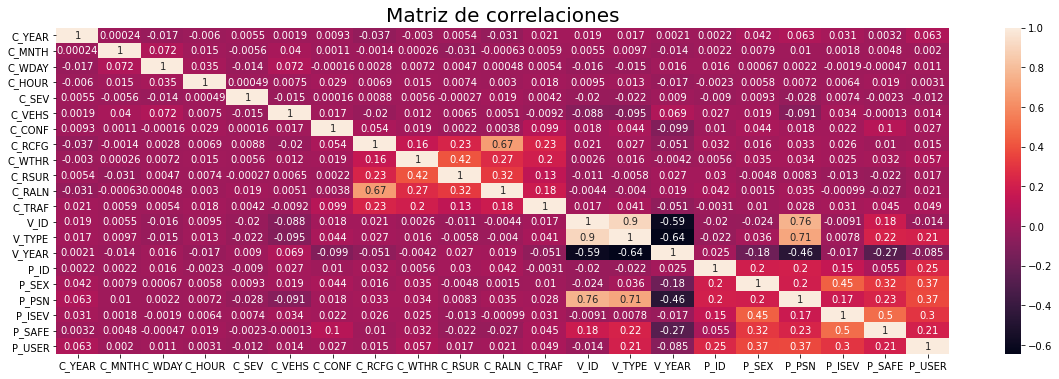

In [32]:
# Matriz de correlacion de variables continuas
import matplotlib.pyplot as pl
import seaborn as sb

correl = db.corr(method='pearson')
pl.figure(figsize=(20, 6))
sb.heatmap(correl, annot=True)
pl.title("Matriz de correlaciones", fontsize =20)
pl.show()

De un simple vistazo podemos observar que por lo general hay una correlación baja entre las variables,  que oscilan entre -0.2 y 0.2. Destacan 4 correlaciones negativas entre V_YEAR y V_ID, V_YEAR y V_TYPE, y viceversa. Las correlaciones más altas se dan entre V_TYPE y V_ID.

### ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?  ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?

Para saber que vehículos y conductores son más (o menos) propensos a tener accidentes tendremos que filtrar la variable **P_PSN** *Person position* a 11 (*Driver* - Conductor). Esto se debe a que un mismo accidente puede estar contabilizado en diferentes líneas (más de una persona involucrada), por lo que un análisis sin este filtro no serñia completamente preciso.

In [33]:
prueba = db

In [34]:
pruebafilt = prueba[prueba['P_PSN'] == 11]  

In [35]:
pruebafilt.head(2)

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,3,2,2,3,100,1,5,...,1,6,1990,1,0,3,11,1,100,1
1,1999,1,1,3,2,2,3,100,1,5,...,2,1,1987,1,0,2,11,1,100,1


Los datos relacionados a personas son:
- **P_ID**: Person sequence number
- **P_SEX**: Person sex
- **P_AGE**: Person age

Consideraremos interesantes para el análisis el género del conductor y la edad, para saber si alguno es más propenso a tener más accidentes.

In [36]:
pruebafilt['P_SEX'].value_counts()

0      2355082
1      1413370
100     157634
Name: P_SEX, dtype: int64

Donde, especificado antes, 0 es relacionado a Male y 1 a Female. 100 son datos no definidos por lo que no los tendremos en cuenta.

0      59.985492
1      35.999466
100     4.015042
Name: P_SEX, dtype: float64


Text(0, 0.5, 'Frecuencia')

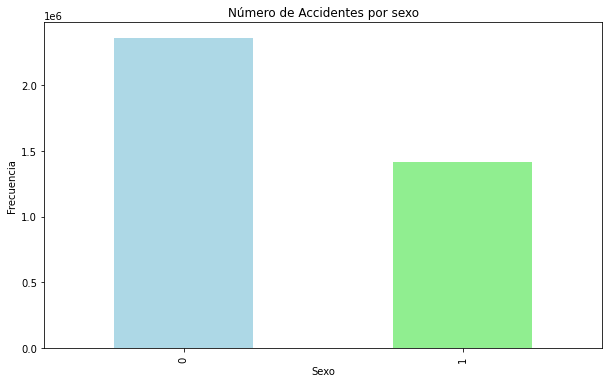

In [37]:
elimsex = pruebafilt[pruebafilt['P_SEX'] != 100]
print(pruebafilt['P_SEX'].value_counts()/sum(pruebafilt['P_SEX'].value_counts())*100)
ax = elimsex['P_SEX'].value_counts().plot(kind='bar',
                                    figsize=(10,6),
                                    title="Número de Accidentes por sexo", color=["lightblue","lightgreen"])
ax.set_xlabel("Sexo")
ax.set_ylabel("Frecuencia")

Vemos que más de la mitad de los accidentes tienen como conductor a un hombre 59.99% frente a un 35.99% de mujeres. Hay un 4% de los datos que no están definidos ni como hombre ni como mujer, y los consideramos nulos.

2    34.539273
3    30.375350
4    22.556102
5    11.752844
1     0.776431
Name: P_AGE, dtype: float64


<AxesSubplot:xlabel='P_AGE', ylabel='count'>

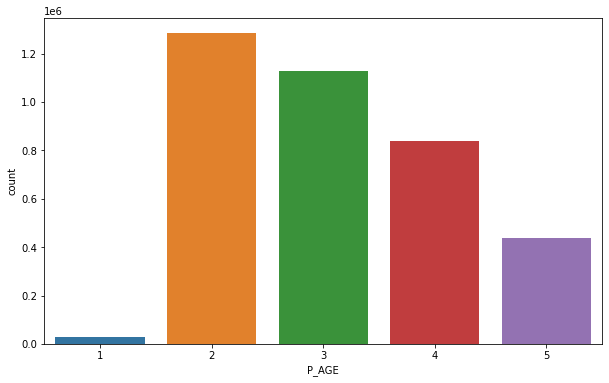

In [38]:
elimage = pruebafilt[pruebafilt['P_AGE'] != 100] 
print(elimage['P_AGE'].value_counts()/sum(elimage['P_AGE'].value_counts())*100)
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.countplot(x ='P_AGE', data = elimage)

Observamos que los más propensos a tener accidentes son las personas de los grupos 2 (16 a 30 años), seguido del grupo 3 (31 a 45 años) y del grupo 4 (46-60 años). Hay menos de un 1% de los accidentes causados por conductores menores de 16 años, edad legal para conducir en Estados Unidos. Los valores por encima de 60 más bajos se pueden relacionar a una vida más sedentaria, sin necesidad de transportarse tanto (trabajo, universidad, etc) y por la experiencia conduciendo.

Los datos de coches que utilizaremos para este análisis serán: 
- **V_ID**: Vehicle sequence number
- **V_TYPE**: Vehicle type
- **V_YEAR**: Vehicle model year

Sería interesante ver qué modelos son más y menos propensos a tener accidentes y de qué modelo serían.

In [39]:
elim1 = pruebafilt[pruebafilt['V_TYPE'] != 100] 

In [40]:
print(elim1["V_TYPE"].value_counts()/sum(elim1["V_TYPE"].value_counts())*100)

1     85.176216
6      3.140388
17     2.743285
14     2.418986
7      1.896072
8      1.640881
5      1.177110
11     0.638478
24     0.458353
9      0.180896
20     0.170187
16     0.130844
22     0.079405
23     0.047638
18     0.044659
19     0.036980
21     0.010298
10     0.009322
Name: V_TYPE, dtype: float64


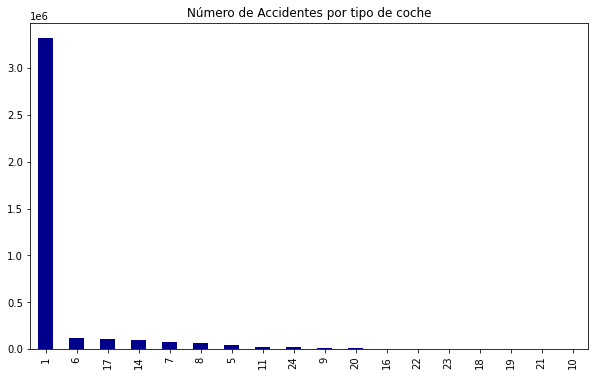

In [41]:
ax = elim1['V_TYPE'].value_counts().plot(kind='bar',
                                    figsize=(10,6),
                                    title="Número de Accidentes por tipo de coche", color=["darkblue"])

Los automóviles que más accidentes tienen son los vehículos ligeros con diferencia (01). Probablemente porque son los más comunes y existen más cantidades de estos vehículos. Los vehículos con menos accidentes serían los autobuses de tamaño pequeño (10).

Si observaramos el número de accidentes por tipo de vehículo y edad:

<AxesSubplot:xlabel='V_TYPE', ylabel='count'>

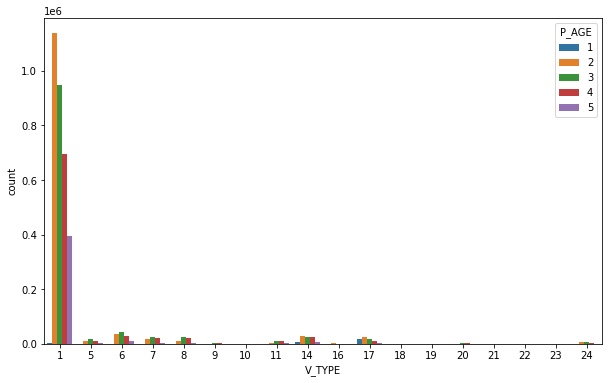

In [42]:
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.countplot(x ='V_TYPE', hue = "P_AGE", data = elim1)

Vemos como la mayoría de accidentes para vehículos ligeros (1) están causados por jóvenes de 16 a 30 años, pero otros tipos de vehículos: furgonetas, camiones, tractores, etc. están principalmente causados por adultos de 31 a 45 años (5, 6, 7, 8).

Las motocicletas (14) y las bicicletas (17) también son principalmente conducidas por jóvenes.


<AxesSubplot:xlabel='V_TYPE', ylabel='count'>

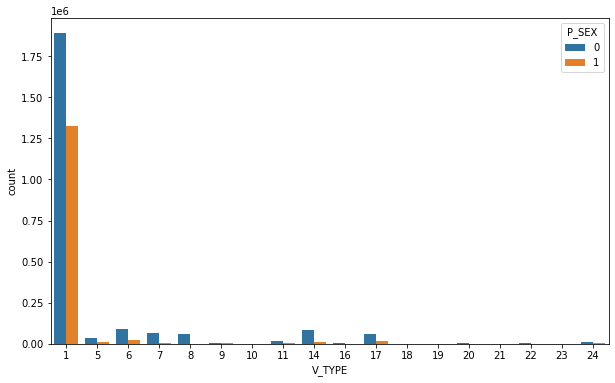

In [43]:
elimsex = elim1[elim1['P_SEX'] != 100]
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.countplot(x ='V_TYPE', hue = "P_SEX", data = elimsex)

Por género, los hombres son más propensos a tener accidentes que las mujeres, sin importar el tipo de coche.

In [44]:
elim2 = pruebafilt[pruebafilt['V_YEAR'] != 100] 

2000    6.122762
1998    5.586712
2002    5.553731
1999    5.465102
2003    5.305050
          ...   
1907    0.000055
1904    0.000055
1910    0.000028
1906    0.000028
1905    0.000028
Name: V_YEAR, Length: 114, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


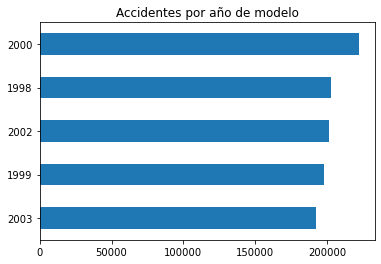

In [45]:
print(elim2["V_YEAR"].value_counts()/sum(elim2["V_YEAR"].value_counts())*100)
print(elim2["V_YEAR"].value_counts().head(5).sort_values().plot(kind = 'barh', title="Accidentes por año de modelo"))

AxesSubplot(0.125,0.125;0.775x0.755)


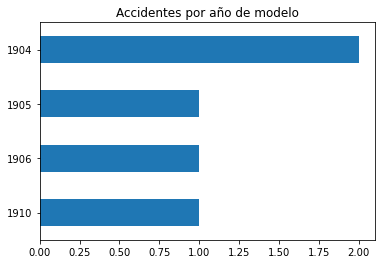

In [46]:
print(elim2["V_YEAR"].value_counts().tail(4).sort_values().plot(kind = 'barh', title="Accidentes por año de modelo"))

Los modelos que más accidentes tienen son los del 2000, con un 6% de los accidentes totales. Los modelos que menos serían los de 1905, 106 y 1910 con 1 solo accidente. 
Sería útil saber cuántos accidentes ha habido por años para saber si esta diferencia está causada por un número mayor de accidentes (causado por ejemplo por un aumentos de coches)

2000    7.172767
2002    7.146761
1999    6.993046
2003    6.976133
2001    6.951885
2004    6.705533
2005    6.696287
2006    6.519572
2007    6.313005
2008    5.771932
2009    5.592516
2010    5.581055
2012    5.494454
2011    5.485692
2013    5.445627
2014    5.153733
Name: C_YEAR, dtype: float64


<AxesSubplot:title={'center':'Accidentes por año'}>

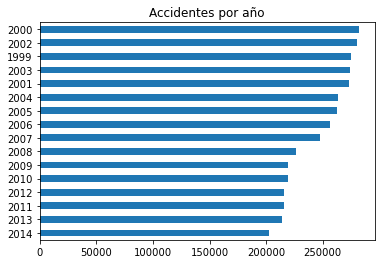

In [47]:
print(pruebafilt["C_YEAR"].value_counts()/sum(pruebafilt["C_YEAR"].value_counts())*100)
pruebafilt["C_YEAR"].value_counts().sort_values().plot(kind = 'barh', title="Accidentes por año")

Y mirando la antigüedad en vez del año del modelo:

In [48]:
# restamos el año menos el año del modelo
pruebafilt["Antigüedad"] = pruebafilt["C_YEAR"] - pruebafilt["V_YEAR"]

In [49]:
# quitamos los valores por encima de 100, ya que están causados porque la columna V_YEAR contenía algunos 0
antiguedad = pruebafilt
antiguedad = antiguedad[antiguedad['Antigüedad'] < 100] 
antiguedad["Antigüedad"].value_counts()

1     272134
2     263320
4     250990
3     250287
5     247957
       ...  
78         4
90         3
95         3
88         1
97         1
Name: Antigüedad, Length: 102, dtype: int64

1     7.504387
2     7.261332
4     6.921319
3     6.901933
5     6.837681
        ...   
78    0.000110
90    0.000083
95    0.000083
88    0.000028
97    0.000028
Name: Antigüedad, Length: 102, dtype: float64


<AxesSubplot:xlabel='Antigüedad', ylabel='count'>

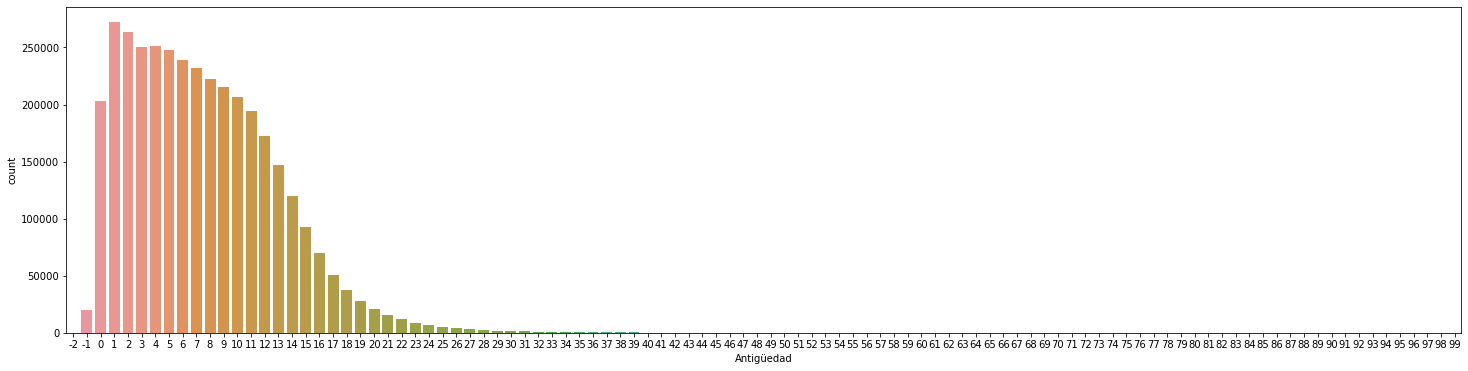

In [50]:
print(antiguedad["Antigüedad"].value_counts()/sum(antiguedad["Antigüedad"].value_counts())*100)
fig, ax = plt.subplots(1, figsize=(25, 6))
sns.countplot(x ='Antigüedad', data = antiguedad)

Los coches de menos antigüedad son los que menos accidentes tienen, probablemente por la inexperiencia del conductor. De manera que sube la antigüedad del coche, baja el número de accidentes, probablemente por reducir el uso del vehículo en gran cantidad.

Es curioso ver como hay número negativos, posiblemente causados por errores del dataset (el modelo de un coche no puede estar por encima del año en el que se produjo el accidente).

#### Conclusiones: 
- Los conductores más propensos a tener accidentes son los hombres con un 59.99% frente a un 35.99% de mujeres, y la edad más propensa se encuentra entre los 16 y 30 años.
- Los vehículos ligeros conforman la mayoría de los accidentes con un  84.48% de los accidentes y los autobuses escolares pequeños los que menos. Los jóvenes son los que más sufren accidentes en vehículos ligeros, motocicletas y bicicletas y los adultos de 31 a 45 años en los demás tipos de vehículos (tractores, camiones, etc.)
- Los coches fabricados alrededor de los 2000 sufren más accidentes que los coches por debajo y por encima de estas fechas. 
- Los coches con menos antigüedad son los que más accidentes tienen, y el número se reduce hasta casi desaparecer a lo largo de la antigüedad del vehículo.

### ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?

Para responder a esta pregunta analizaremos la variable **P_ISEV** ("medical treatment required"), que está compuesta por:

In [51]:
db["P_ISEV"].value_counts()/sum(db["P_ISEV"].value_counts())*100

2      52.443996
1      40.529762
100     6.337654
3       0.688588
Name: P_ISEV, dtype: float64

- 100: que serían tanto a los coches aparcados como los valores no conocidos
- 1: accidente sin daño
- 2: accidente con daño
- 3: accidente mortal

Vemos que está compuesto principalmente por accidentes con daño con **52.44%** , pero mortales son por debajo del **1%**. Un **40%** son accidentes sin daño.

In [54]:
elim3 = db
elim3.columns

Index(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'C_SEV', 'C_VEHS', 'C_CONF',
       'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE',
       'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE',
       'P_USER'],
      dtype='object')

Analizaremos los accidentes mortales comparándolos con las distintas variables para comprobar cuáles son las mayores causantes.

<AxesSubplot:xlabel='C_HOUR', ylabel='count'>

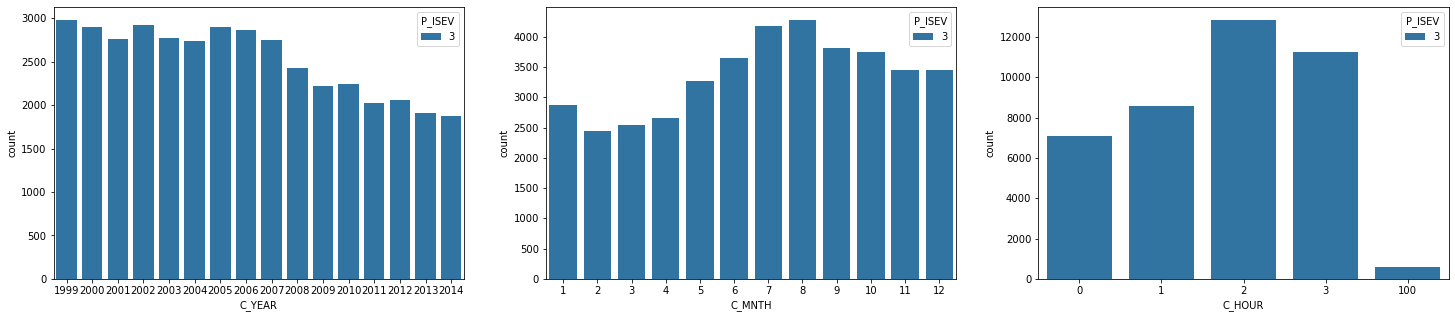

In [56]:
elim3 = elim3[elim3['C_MNTH'] != 100] 
elim3 = elim3[elim3['C_MNTH'] != 100]
elim3 = elim3[elim3['P_ISEV'] == 3] 
fig, ax = plt.subplots(1, 3, figsize=(25, 5))

sns.countplot(x ='C_YEAR', hue="P_ISEV", data = elim3,ax=ax[0])
sns.countplot(x ='C_MNTH', hue="P_ISEV", data = elim3, ax=ax[1])
sns.countplot(x ='C_HOUR', hue="P_ISEV", data = elim3, ax=ax[2])

Los años en los que más accidentes mortales había se ha visto reducido a lo largo de los años, con un incremento en 2005 y 2006. Los meses dónde más accidentes hay suelen estar relacionadas a épocas festivas (meses de navidad, verano, etc.). Las horas donde más accidentes mortales se producen son por la tarde y por la noche.

<AxesSubplot:xlabel='C_RCFG', ylabel='count'>

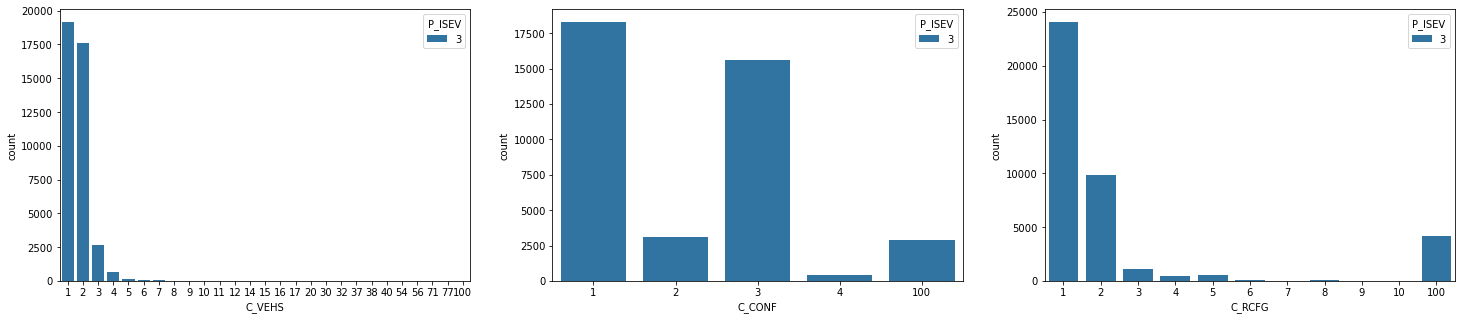

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))

sns.countplot(x ='C_VEHS', hue="P_ISEV", data = elim3, ax=ax[0])
sns.countplot(x ='C_CONF', hue="P_ISEV", data = elim3, ax=ax[1])
sns.countplot(x ='C_RCFG', hue="P_ISEV", data = elim3, ax=ax[2])

La mayoría de los accidentes mortales:
- **C_VEHS**: Tienen uno o dos vehículos involucrados,
- **C_CONF**:Con un solo vehículo chocando un objeto, persona o por vueltas del propio coche o con dos vehículos en distintas direcciones.
- **C_RCFG**:La mayoría de los accidentes son en carreteras que no son intersecciones y, en segundo lugar en intersecciones de un lugar público.

<AxesSubplot:xlabel='C_TRAF', ylabel='count'>

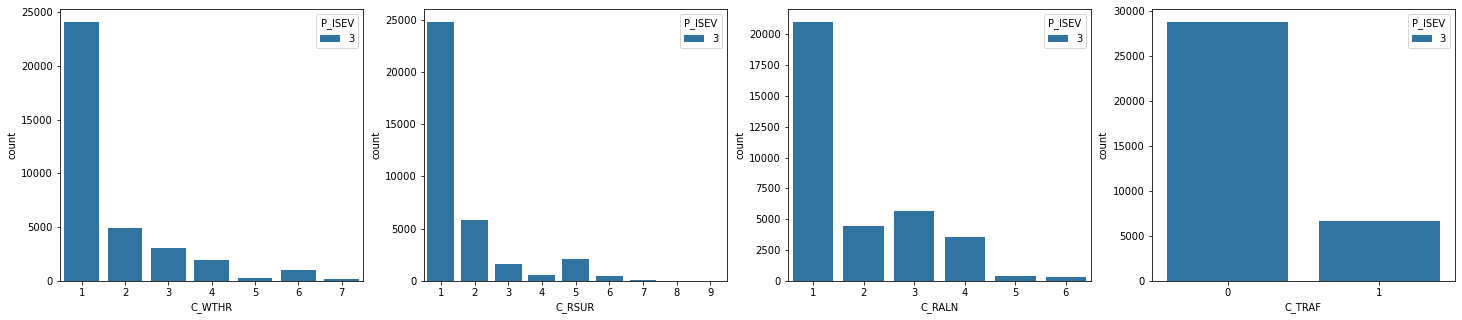

In [60]:
elim3 = elim3[elim3['C_WTHR'] != 100]
elim3 = elim3[elim3['C_RSUR'] != 100]
elim3 = elim3[elim3['C_RALN'] != 100]
elim3 = elim3[elim3['C_TRAF'] != 100]

fig, ax = plt.subplots(1, 4, figsize=(25, 5))

sns.countplot(x ='C_WTHR', hue="P_ISEV", data = elim3, ax=ax[0])
sns.countplot(x ='C_RSUR', hue="P_ISEV", data = elim3, ax=ax[1])
sns.countplot(x ='C_RALN', hue="P_ISEV", data = elim3, ax=ax[2])
sns.countplot(x ='C_TRAF', hue="P_ISEV", data = elim3, ax=ax[3])

- **C_WTHR**: Los mayores accidentes mortales, curiosamente son cuando hace sol. Esto puede ser explicado porque el número de coches en movimiento es más alto o porque es más probable que el cielo esté despejado.
- **C_RSUR**: Lo mismo con el tipo de suelo, hay más probabilidad de que se realicen viajes. Cuando está mojado (2) y helado (5) también se producen accidentes mortales.
- **C_RALN**: Las carreteras rectas y sin pendiente son las más propensas a tener accidentes, esto puede ser como mencionado antes por el número de carreteras que son así o porque las carreteras de más velocidad tienen estas características y tienden a ser más mortales. Carreteras curvas y con pendiente también tienen un número alto de accidentes mortales (3)
- **C_TRAF**: Las carreteras no señalizadas son mucho más propensas a tener accidentes.

<AxesSubplot:xlabel='V_YEAR', ylabel='count'>

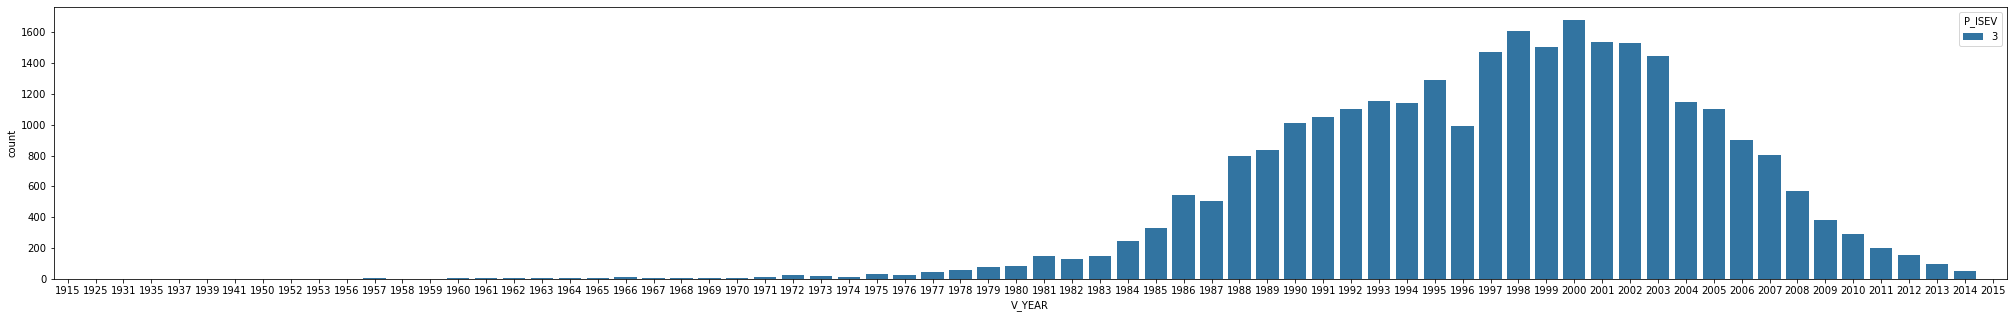

In [61]:
elim3 = elim3[elim3['V_YEAR'] != 100]
fig, ax = plt.subplots(1, figsize=(35, 5))
sns.countplot(x ='V_YEAR', hue="P_ISEV", data = elim3)

Los coches con más accidentes mortales se encuentran entre 1997 y 2003, luego ha decrecido notablemente, posiblemente por el incremento del control y seguridad de los vehículos.

<AxesSubplot:xlabel='V_TYPE', ylabel='count'>

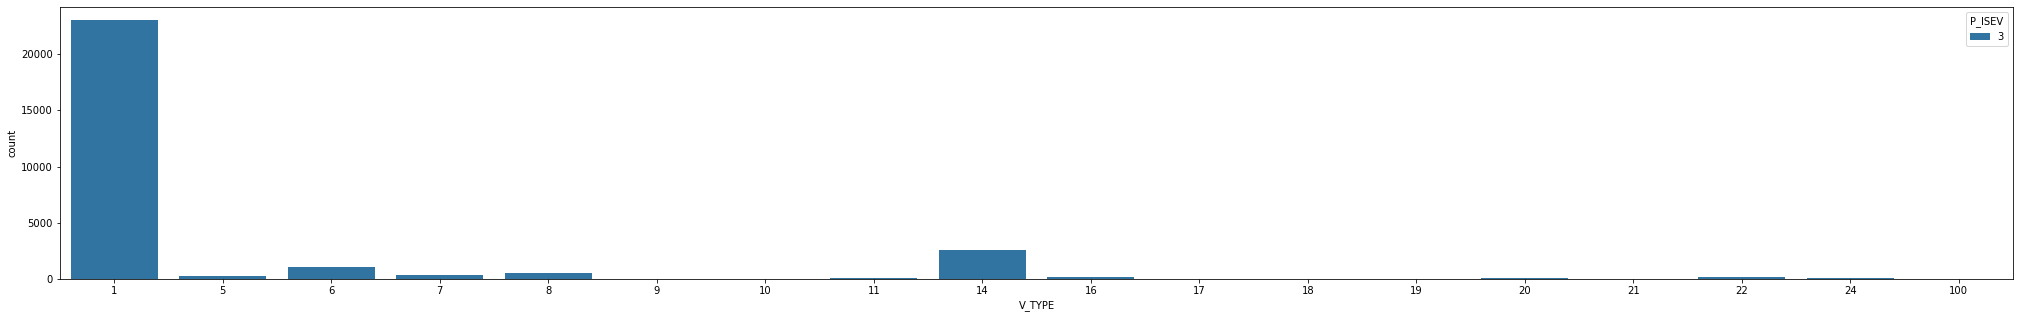

In [62]:
fig, ax = plt.subplots(1, figsize=(35, 5))
sns.countplot(x ='V_TYPE', hue="P_ISEV", data = elim3)

Los accidentes mortales, según el tipo de coche están principalmente causados por vehículos ligeros y motocicletas (14), en menor cantidad.

<AxesSubplot:xlabel='P_PSN', ylabel='count'>

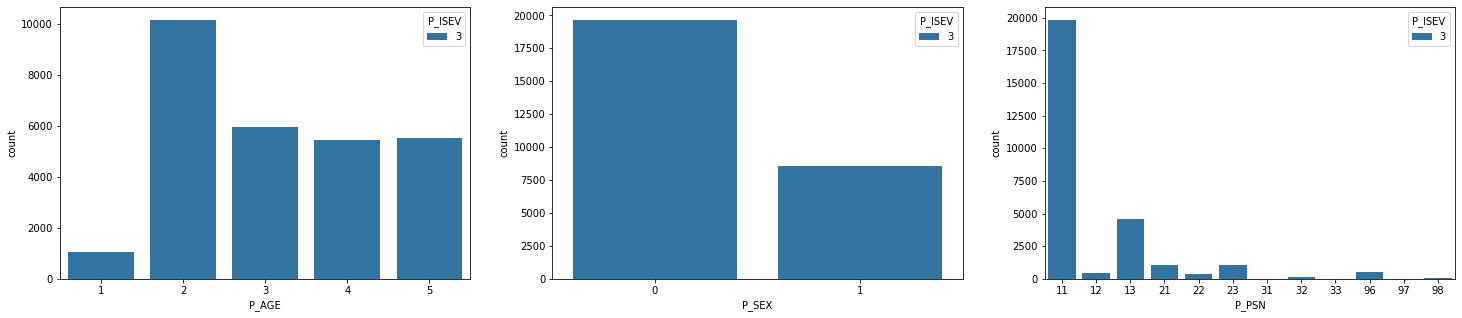

In [63]:
elim3 = elim3[elim3['P_SEX'] != 100]
elim3 = elim3[elim3['P_PSN'] != 100]

fig, ax = plt.subplots(1, 3, figsize=(25, 5))

sns.countplot(x ='P_AGE', hue="P_ISEV", data = elim3, ax=ax[0])
sns.countplot(x ='P_SEX', hue="P_ISEV", data = elim3, ax=ax[1])
sns.countplot(x ='P_PSN', hue="P_ISEV", data = elim3, ax=ax[2])

- Las edades que tienen más accidentes mortales son los jóvenes de 16-30 años, que ya vimos anteriormente que eran los que más accidentes solían tener. De igual manera, los hombres suelen tener más accidentes mortales al igual que su número total de accidentes era mayor.
- Las mayores muertes se encuentran entre los conductores (11), aunque también observamos muertes en el puesto de copiloto de coche o moto (13), y en menos cantidad en la parte trasera a la derecha (23).

<AxesSubplot:xlabel='P_USER', ylabel='count'>

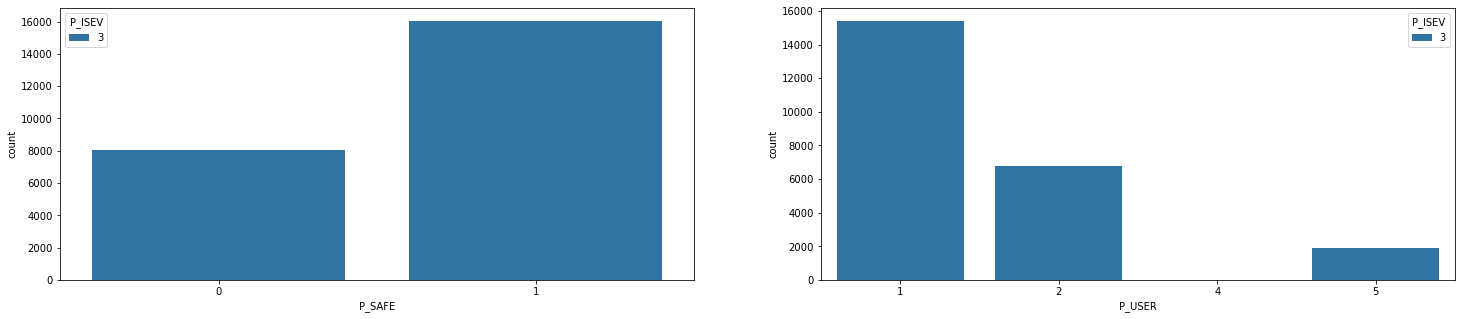

In [64]:
elim3 = elim3[elim3['P_SAFE'] != 100]
elim3 = elim3[elim3['P_USER'] != 100]

fig, ax = plt.subplots(1, 2, figsize=(25, 5))

sns.countplot(x ='P_SAFE', hue="P_ISEV", data = elim3, ax=ax[0])
sns.countplot(x ='P_USER', hue="P_ISEV", data = elim3, ax=ax[1])

- **P_SAFE**: Curiosamente el número es más alto para personas que utilizaban mecanismos de seguridad (1), aunque el número de accidentes totales también indica que hay más accidentes con personas usando protección de algún tipo
- **P_USER**: El conductor (1), es el más propenso a tener accidentes mortales, seguido por los pasajeros y por último los motoristas.

-----

### PLUS: complementar con datos abiertos de clima (aunque Canadá es muy grande) y de otra tipología, ¿hay algún tipo de relación con temperaturas medias, precipitación media del día/mes, nieve...? ¿a más días festivos o de vacaciones, más accidentes? etc.

Para realizar esta pregunta, vamos a llevar a cabo un análisis del número de accidentes con las variable **C_WTHR, C_MNTH y C_RSUR**, ya que creemos que tanto la época del año como el estado de las carreteras y el clima de Canadá puede afectar al número de accidentes que haya.

Para ello, como hemos realizado anteriormente, seleccionamos unicamente los accidentes que tengan a los conductores como posición principal con el fin de que no se repita el siniestro. 

In [65]:
prueba2 = db
plus = prueba2[prueba2['P_PSN'] == 11]  
plus

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,3,2,2,3,100,1,5,...,1,6,1990,1,0,3,11,1,100,1
1,1999,1,1,3,2,2,3,100,1,5,...,2,1,1987,1,0,2,11,1,100,1
3,1999,1,1,1,2,1,1,100,5,3,...,1,1,1986,1,0,4,11,1,100,1
5,1999,1,1,2,2,3,100,100,1,2,...,1,1,1984,1,0,2,11,1,100,1
6,1999,1,1,2,2,3,100,100,1,2,...,2,1,1991,1,0,2,11,1,100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860397,2014,100,100,100,2,100,100,1,100,100,...,10,1,100,1,1,5,11,1,100,1
5860398,2014,100,100,100,2,100,100,1,100,100,...,11,1,100,1,1,2,11,1,100,1
5860399,2014,100,100,100,2,100,100,1,100,100,...,12,1,100,1,1,4,11,1,100,1
5860400,2014,100,100,100,2,100,100,1,100,100,...,13,7,100,1,0,2,11,1,100,1


In [66]:
plus = plus.loc[:, ['C_WTHR', 'C_MNTH', 'C_RSUR']]
plus = plus[plus['C_MNTH'] != 100]
plus = plus[plus['C_WTHR'] != 100]
plus = plus[plus['C_RSUR'] != 100]

En primer lugar, realizamos una matriz de correlación para hacer un simple estudio de las correlaciones existentes entre las variables, y para ver cómo afectan unas a las otras. En primer lugar, realizamos una matriz de correlación para hacer un simple estudio de las correlaciones existentes entre las variables, y para ver cómo afectan unas a las otras. 

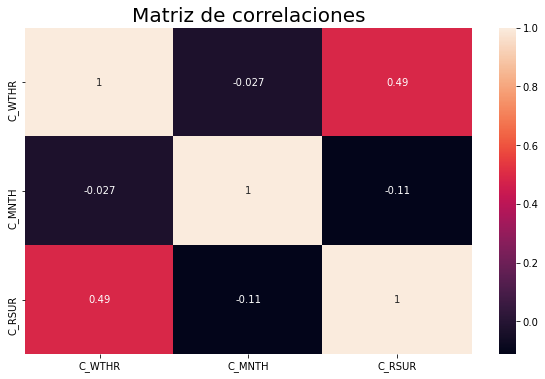

In [67]:
correl = plus.corr()

correl = plus.corr(method='pearson')
pl.figure(figsize=(10, 6))
sb.heatmap(correl, annot=True)
pl.title("Matriz de correlaciones", fontsize =20)
pl.show()

Observaciones:


   - Existe una correlación negativa entre el mes y el clima en Canadá, de tal forma que una variable no influencia a la otra. 
   - Lo mismo ocurre con el estado en el que se encuentra la carretera. Correlación negativa entre el mes y el estado de la carretera (igual que la anterior)
   - Por otro lado, existe una correlación positiva entre el clima y el estado de la carretera, de tal forma que, si por ejemplo hace sol, la carretera estará seca. 


Aunque no exista correlación con la variable “mes”, vamos a ver el **número de accidentes que hay mensualmente**:


8     9.375857
7     9.216732
6     9.192416
9     9.109206
10    9.014372
11    8.427227
12    8.409939
5     8.261582
1     8.142272
2     7.072409
3     6.967368
4     6.810621
Name: C_MNTH, dtype: float64


Text(0, 0.5, 'Número de accidentes')

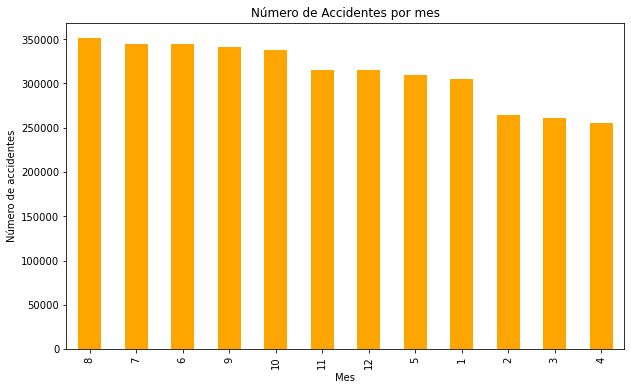

In [68]:
mes = plus[plus['C_MNTH'] != 100]
print(plus['C_MNTH'].value_counts()/sum(plus['C_MNTH'].value_counts())*100)
ax = mes['C_MNTH'].value_counts().plot(kind='bar',
                                    figsize=(10,6),
                                    title="Número de Accidentes por mes", color=["orange"])
ax.set_xlabel("Mes")
ax.set_ylabel("Número de accidentes")


Vemos que el número de accidentes es bastante constante a lo largo del año, ya que no hay ningún mes que destaque por tener un mayor/menor número de siniestros. Se podría decir que los meses con menos accidentes son marzo y abril, mientras que agosto (mes de vacaciones para la mayoría de canadienses) es el mes con mayor número de accidentes.  

- Ahora veremos el número de accidentes según las **condiciones meteorológicas**:

1    70.918376
2    11.008469
3    10.514661
4     5.392046
6     1.439899
5     0.492365
7     0.234185
Name: C_WTHR, dtype: float64


Text(0, 0.5, 'Número de accidentes')

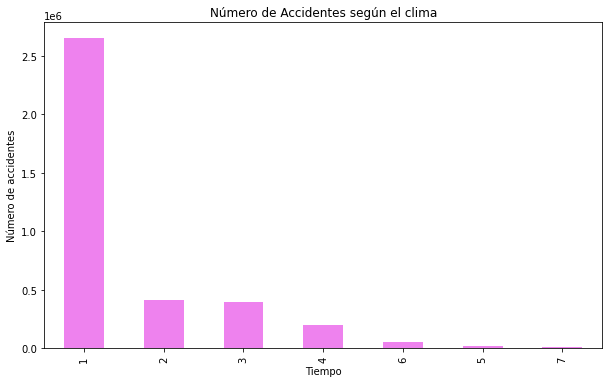

In [69]:
mes = plus[plus['C_WTHR'] != 100]
print(plus['C_WTHR'].value_counts()/sum(plus['C_WTHR'].value_counts())*100)
ax = mes['C_WTHR'].value_counts().plot(kind='bar',
                                    figsize=(10,6),
                                    title="Número de Accidentes según el clima", color=["violet"])
ax.set_xlabel("Tiempo")
ax.set_ylabel("Número de accidentes")

Observamos que los días soleados destacan por ser los días en los que ocurren un mayor número de siniestros. Seguido de los días soleados, aunque con muchos menos accidentes, los días nublados pero sin precipitaciones, que se equiparan a los días con lluia, seguidos de los días en los que nieva. 

Esta observación se podría deber a que en los días de sol la gente en general suele llevar menos precauciones que un dia de lluvia, por ejemplo. Así en número de accidentes de tráfico es mayor.

In [70]:
group = plus.groupby("C_WTHR")
group.count()

,C_MNTH,C_RSUR
C_WTHR,,
1,2654011,2654011
2,411975,411975
3,393495,393495
4,201789,201789
5,18426,18426
6,53886,53886
7,8764,8764


<AxesSubplot:xlabel='C_MNTH', ylabel='count'>

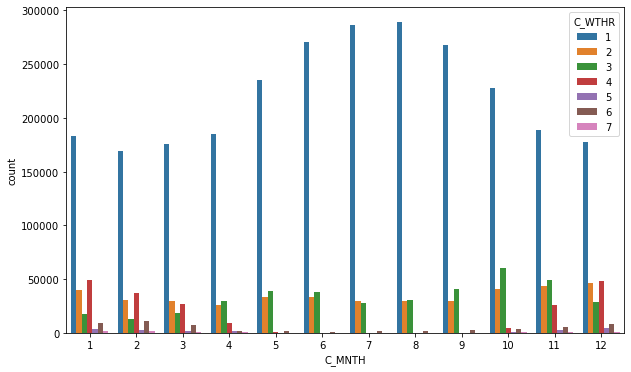

In [71]:
fig, ax = plt.subplots(1, figsize=(10,6))
sns.countplot(x ='C_MNTH', hue = "C_WTHR", data = plus)

Cómo se ha mencionado anteriormente, los días soleados destacan por mayoría en ser los días con mayor número de accidentes, siendo el número de siniestros mayor en los meses de julio y agosto, seguido por junio y sptiembre. Es decir, en la época de verano. Por otro lado, los accidentes incrementan los días de nieve en los meses de diciembre, enero y febrero. Por otro lado, los accidentes por lluvia incrementan en los meses de septiembre, octubre y noviembre.

Pero en general, en cada mes, los dias de sol contienen el mayor número de accidentes (lo cual no significa que en todos los meses haya un mayor número de días de sol, sino que los accidentes pueden estar concentrados en pocos días).

Ahora realizamos el mismo análisis teniendo en cuenta las **condiciones de la carretera**:

<AxesSubplot:title={'center':'Número de Accidentes según las Condiciones de la Vía'}>

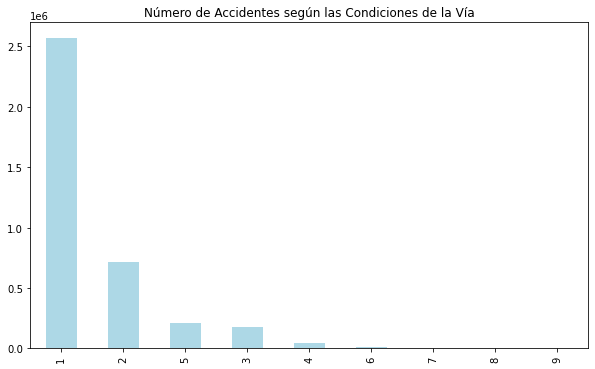

In [72]:
plus['C_RSUR'].value_counts().plot(kind='bar',
                                    figsize=(10,6),
                                    title="Número de Accidentes según las Condiciones de la Vía", color=["lightblue"])

Siguiendo este gráfico, es bastante evidente que el número de accidentes es mayor cuando la carretera esta seca. Seguido a este, vemos que los accidentes también se deben a una via húmeda y, en su medida, a una carretera con hielo o con nieve.

Al igual que hemos visto antes, el hecho de que la mayoría de accidentes se produzca cuando la vía esta seca, se puede deber principalmente a:
   - que la media de dias en los que no llueve/nieva sea alta
   - que cuando la carretera esta seca, la gente toma menor precaución que cuando sabe que hay nieve, o esta húmeda

A continuación analizaremos estas condiciones de la via a lo largo de los 12 meses del año:

<AxesSubplot:xlabel='C_MNTH', ylabel='count'>

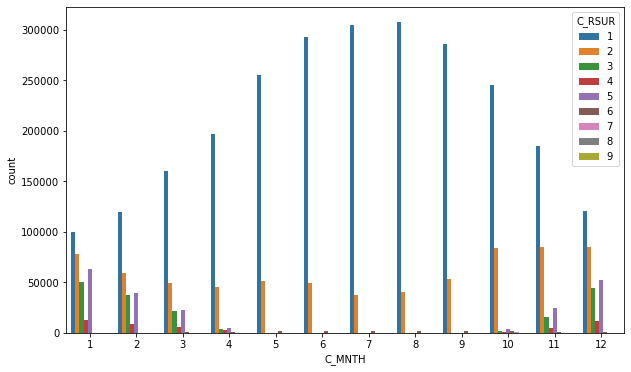

In [73]:
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.countplot(x ='C_MNTH', hue = "C_RSUR", data = plus)

Canadá es el segundo país más grande del mundo, lo cual implica climas variados a lo largo del mismo:
- el norte de Canadá es extremadamente frío, con veranos que duran menos de dos meses, 
- la zona sur, en cambio, es más cálida.

El clima de la zona de Vancouver - *costa oeste*, es templado. Aquí llueve casi la mitad de todo el invierno, pero en cambio, nunca nieva, y en verano hace sol. 

Cerca de *Toronto* el clima es de tipo continental. Los veranos son húmedos y calurosos (con temperaturas medias de 26ºC) y los inviernos, por lo contrario, fríos y con nieve (temperaturas medias de 0ºC). En promedio, a lo largo del año llueve 7 días al mes.

El hecho de que el clima de Canadá sea variado, supone que no podamos sacar grandes conclusiones con respecto a los accidentes y su clima. Si que hemos podido observar que el hecho de que llueva, nieve, o haga frío, no suponen un incremento en el número de accidentes de tráfico.

---